In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
class MeanFieldVariationalDistribution(nn.Module):
    def __init__(self, nb_dim, mu=0.0, sigma=1.0, device='cpu'):
        super(MeanFieldVariationalDistribution, self).__init__()
        self.device = device
        self.nb_dim = nb_dim
        self.mu = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        self.rho = nn.Parameter(torch.Tensor(nb_dim), requires_grad=True)
        
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu)
            
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma)
        
        rho = torch.log(torch.exp(sigma) - 1)
        
        nn.init.constant_(self.mu, mu)
        nn.init.constant_(self.rho, rho)
        
    def set_mu(self, mu):
        if not torch.is_tensor(mu):
            mu = torch.tensor(mu).float()
        nn.init.constant_(self.mu, mu)
        
        
    def set_rho(self, rho):
        if not torch.is_tensor(rho):
            rho = torch.tensor(rho).float()
        nn.init.constant_(self.rho, rho)
       
    def set_sigma(self, sigma):
        if not torch.is_tensor(sigma):
            sigma = torch.tensor(sigma).float()
        rho = self._sigma_to_rho(sigma)
        self.set_rho(rho)
        
    @property
    def sigma(self):
        return self._rho_to_sigma(self.rho)
        
    def sample(self, n=1):
        sigma = self._rho_to_sigma(self.rho)
        epsilon = torch.randn(size=(n,self.nb_dim)).to(self.device)
        return epsilon.mul(sigma).add(self.mu)
    
    def _rho_to_sigma(self, rho):
        sigma = torch.log(1 + torch.exp(rho))
        return sigma

    def _sigma_to_rho(self, sigma):
        rho = torch.log(torch.exp(sigma) - 1)
        return rho
    
    def log_prob(self, z):
        S = torch.diag(self.sigma)
        return torch.distributions.multivariate_normal.MultivariateNormal(self.mu, scale_tril=S).log_prob(z).unsqueeze(-1)

# Variational Distribution #

In [4]:
q = MeanFieldVariationalDistribution(1)

<IPython.core.display.Javascript object>


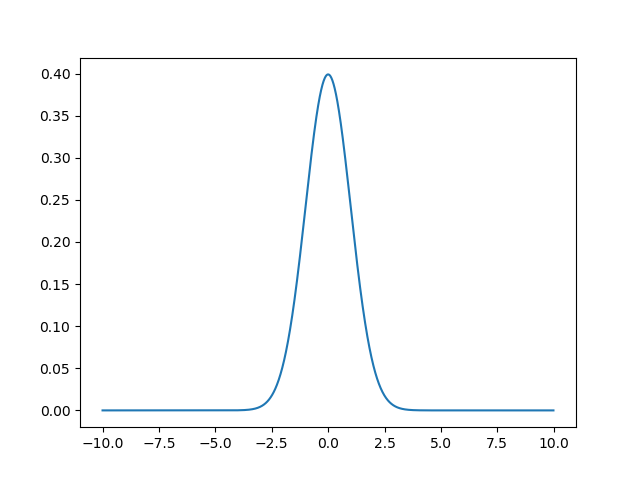

In [5]:
%matplotlib notebook
x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), q.log_prob(x_lin).exp().detach().cpu().numpy())
plt.show()

# Prior #

In [6]:
prior_mu = torch.tensor([0.0])
prior_sigma = torch.tensor([[1.0]])

In [7]:
def prior(x):
    return torch.exp(logprior(x))

def logprior(x):
    return torch.distributions.multivariate_normal.MultivariateNormal(prior_mu, scale_tril=prior_sigma).log_prob(x).unsqueeze(-1)

# Likelihood #

In [8]:
mixture = [torch.distributions.normal.Normal(-5.0, 0.1),
           torch.distributions.normal.Normal(-5.5, 0.2),
           torch.distributions.normal.Normal(-6.0, 0.1)]
proportions = torch.tensor([0.01, 0.19, 0.8])

In [9]:
def likelihood(x):
    return torch.exp(loglikelihood(x))

def loglikelihood(x):
    logp = [None]*len(mixture)
    for j in range(len(mixture)):
        logp[j] = mixture[j].log_prob(x) + proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

# Posterior #

In [10]:
def posterior(x):
    return prior(x)*likelihood(x)

In [11]:
def logposterior(x):
    return logprior(x) + loglikelihood(x)

In [35]:
q = MeanFieldVariationalDistribution(1)

In [36]:
q.mu = nn.Parameter(torch.tensor([-5.5]), requires_grad=False)
q.rho = nn.Parameter(torch.tensor([-10.0]), requires_grad=True)

<IPython.core.display.Javascript object>


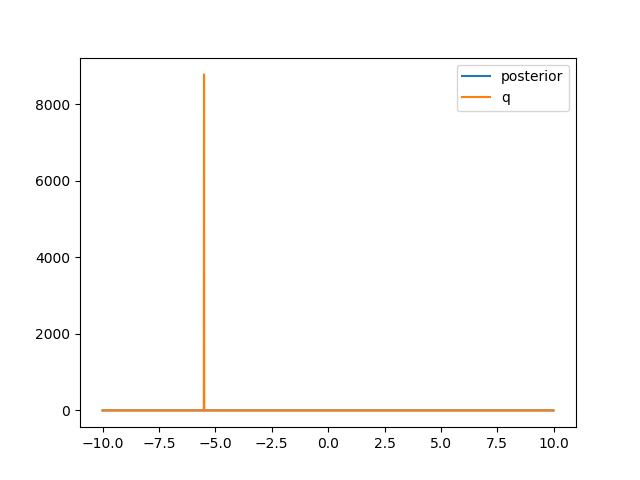

In [37]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(posterior(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*posterior(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()

In [40]:
n_samples_ELBO = 1

In [41]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

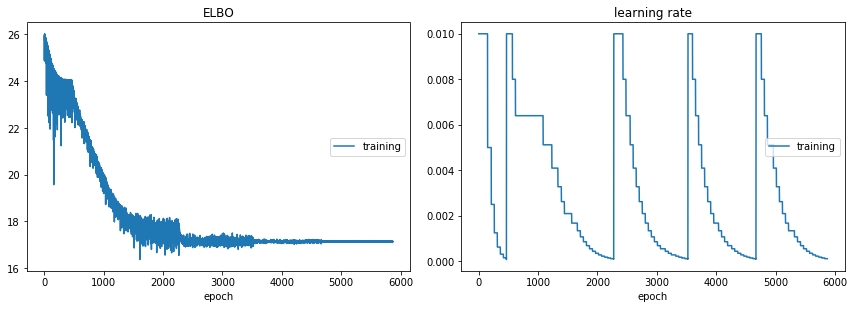

ELBO:
training   (min:   16.366, max:   26.074, cur:   17.138)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [42]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        if n_samples_ELBO > 1000:
            break
        else:
            optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.8)
            n_samples_ELBO = n_samples_ELBO*10
        

<IPython.core.display.Javascript object>


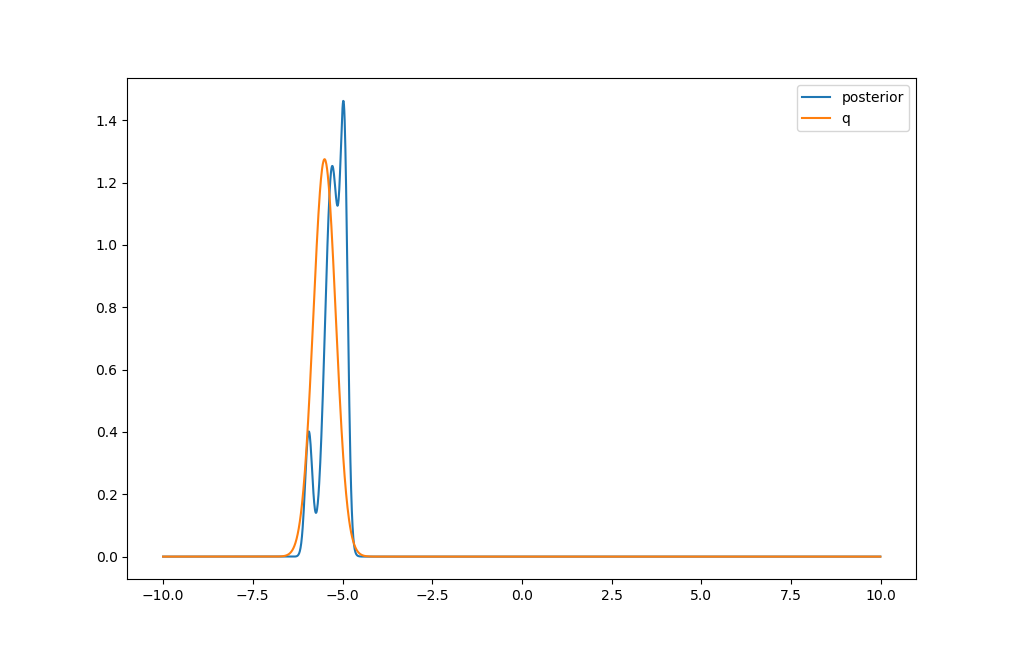

In [43]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(posterior(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*posterior(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()

In [24]:
q.mu = nn.Parameter(torch.tensor([-5.5]), requires_grad=True)
q.rho = nn.Parameter(torch.tensor([-10.0]), requires_grad=False)